In [264]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
from scipy import stats
from scipy.special import inv_boxcox
plt.style.use('ggplot')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [265]:
df = pd.read_csv('WAG_C_M_2019.csv', sep=';', index_col='month', parse_dates=['month'], dayfirst=True)
df.rename(columns={'WAG_C_M': 'zp'}, inplace=True)
df.tail()

,zp
month,
2019-02-01,43062.0
2019-03-01,46324.0
2019-04-01,48030.0
2019-05-01,47926.0
2019-06-01,49840.0


## Визуальный анализ ряда

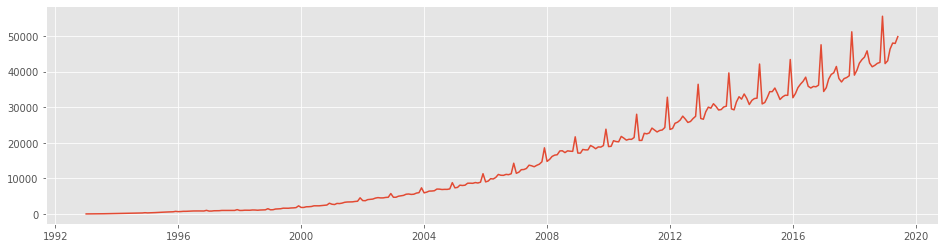

In [266]:
plt.figure(figsize=(16,4))
plt.plot(df);

In [267]:
print('Критерий Дика-Фуллера, pvalue=%f' % sm.tsa.stattools.adfuller(df['zp'])[1])

Критерий Дика-Фуллера, pvalue=0.998598


Очевидно, что ряд нестационарен.

Сделаем декомпозицию ряда на линию тренда, сезонность и остатки:

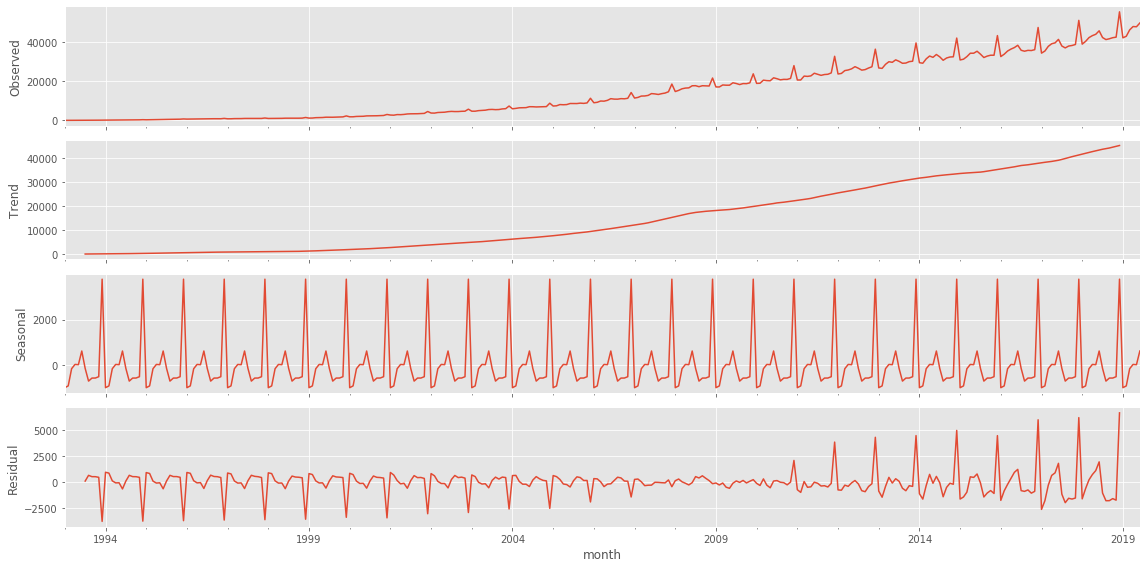

In [295]:
sm.tsa.seasonal_decompose(df['zp']).plot().set_figure(figsize(16, 8))

## Стабилизация дисперсии

Применим преобразование Бокса-Кокса, чтобы стабилизировать дисперсию и посмотрим, что у нас получится

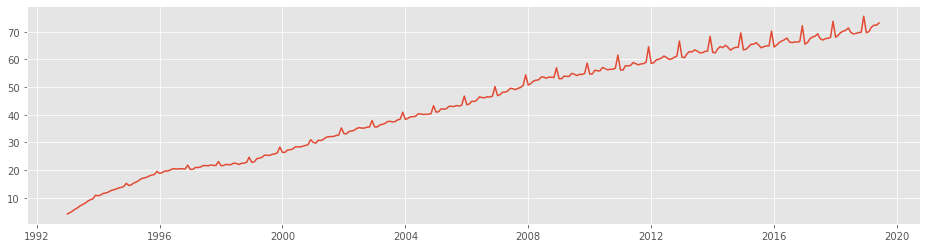

In [269]:
df['zp_box'], lmbda = stats.boxcox(df['zp'])
plt.figure(figsize=(16,4))
plt.plot(df.index, df['zp_box']);

In [270]:
print('Оптимальный критерий преобразования Бокса-Кокса (стебали же их в школе, наверное): %f' % lmbda)
print('Критерий Дика-Фуллера, pvalue=%f' % sm.tsa.stattools.adfuller(df['zp_box'])[1])

Оптимальный критерий преобразования Бокса-Кокса (стебали же их в школе, наверное): 0.285295
Критерий Дика-Фуллера, pvalue=0.700396


## Выбор порядка дифференцирования

Ряд продолжает быть нестационарным, как визуально, так и по критерию Дика-Фуллера. Попробуем использовать сезонное дифференцирование.

Критерий Дика-Фуллера, pvalue=0.122057


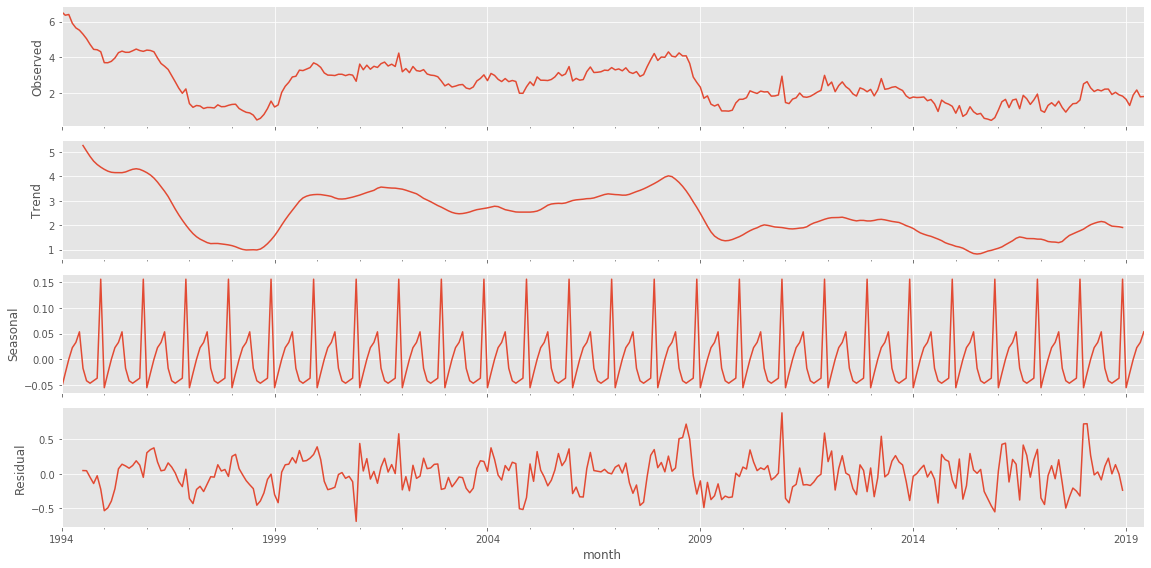

In [271]:
df['zp_box_diff1'] = df['zp_box'] - df['zp_box'].shift(12)
sm.tsa.seasonal_decompose(df['zp_box_diff1'][12:]).plot().set_figure(figsize(16, 8))
print('Критерий Дика-Фуллера, pvalue=%f' % sm.tsa.stattools.adfuller(df['zp_box_diff1'][12:])[1])

Ряд все еще нестационарен как по критерию Дика-Фуллера, так и визуально. Линия тренда все еще хорошо прослеживается. Применим еще и обычное дифференцирование

Критерий Дика-Фуллера, pvalue=0.000000000586


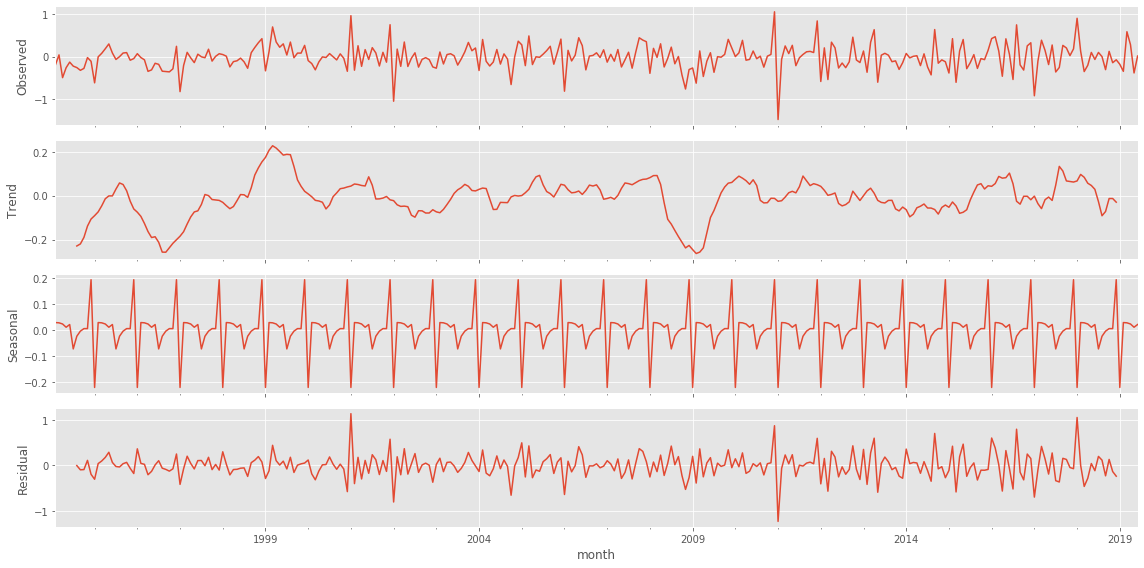

In [272]:
df['zp_box_diff2'] = df['zp_box_diff1'] - df['zp_box_diff1'].shift(1)
sm.tsa.seasonal_decompose(df['zp_box_diff2'][13:]).plot().set_figure(figsize(16, 8))
print('Критерий Дика-Фуллера, pvalue=%.12f' % sm.tsa.stattools.adfuller(df['zp_box_diff2'][13:])[1])

Отлично, мы избавились от тренда, и критерий Дика-Фуллера очень уверенно отвергает гипотезу нестационарности ряда

## Выбор начальных приближений p, q, P, Q

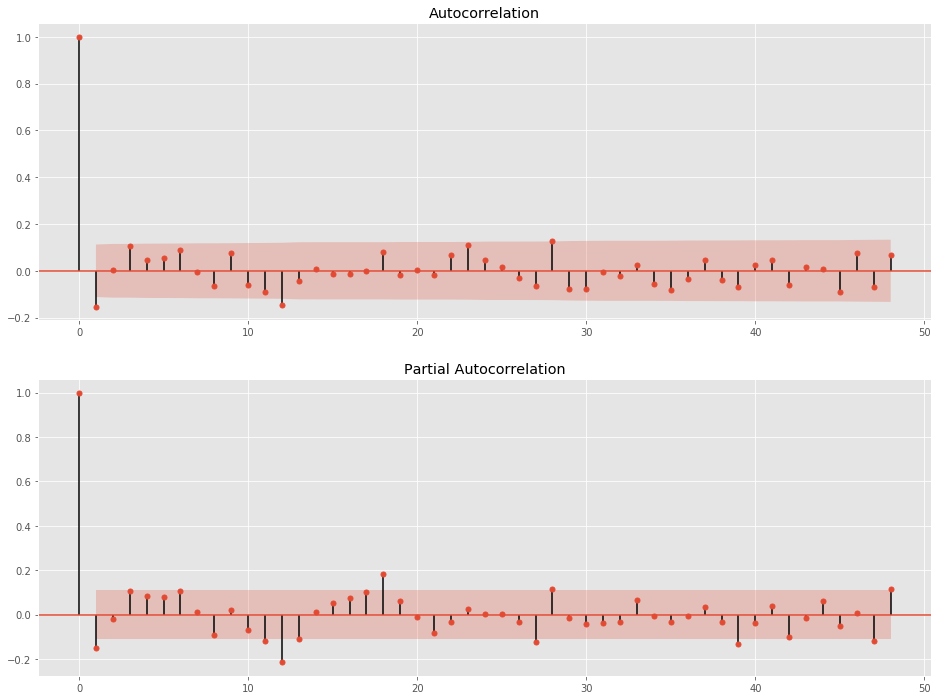

In [273]:
plt.figure(figsize=(16,12))
ax1 = plt.subplot(2, 1, 1)
ax2 = plt.subplot(2, 1, 2)

sm.tsa.graphics.plot_acf(df['zp_box_diff2'][13:], ax=ax1, lags=48)
sm.tsa.graphics.plot_pacf(df['zp_box_diff2'][13:], ax=ax2, lags=48)

plt.show()

Выбираем по графикам автокорреляции и частичной автокорреляции начальные приближения Q, q, P, p

In [277]:
p = 11 # последний несезонный лаг, при котором частичная автокорреляция значима = 11
q = 1 # последний несезонный лаг, при котором автокорреляция значима = 1
d = 1 # обычное дифференцирование делали 1 раз

P = 1 # последний значимый сезонный лаг, при котором частичная автокорреляция значима = 12
Q = 1 # последний значимый сезонный лаг, при котором автокорреляция значима = 12
D = 1 # сезонное дифференцирование делали 1 раз

## Обучение и сравнение моделей-кандидатов. Выбор победителя

In [278]:
ps = range(0, p + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
Qs = range(0, Q + 1)

params = list(itertools.product(ps, qs, Ps, Qs))
print('Всего переберем %i комбинаций.' % len(params))

Всего переберем 96 комбинаций.


In [279]:
warnings.filterwarnings('ignore')

best_aic = float("inf")
best_model = None
best_param = None

model_results = []


for param in params:
    try:
        model = sm.tsa.statespace.SARIMAX(
            df['zp_box'], 
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
        
    except ValueError:
        print('something goes wrong with params: ', param)
        continue
    
    if model.aic < best_aic:
        best_model = model
        best_aic = model.aic
        best_param = param
    
    model_results.append([param, model.aic])
    
warnings.filterwarnings('default')

something goes wrong with params:  (2, 1, 0, 0)
something goes wrong with params:  (2, 1, 0, 1)
something goes wrong with params:  (2, 1, 1, 0)
something goes wrong with params:  (2, 1, 1, 1)


In [280]:
result_df = pd.DataFrame(model_results, columns=['params', 'aic']).sort_values(by = 'aic', ascending=True)
result_df.head()

,params,aic
90,"(11, 1, 1, 0)",118.081702
86,"(11, 0, 1, 0)",118.384133
91,"(11, 1, 1, 1)",120.028972
87,"(11, 0, 1, 1)",120.106134
46,"(6, 0, 1, 0)",120.397632


Лушей оказалась модель с p=11, q=1, P=1, Q=0.

In [281]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                              zp_box   No. Observations:                  318
Model:             SARIMAX(11, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 -45.041
Date:                             Thu, 08 Aug 2019   AIC                            118.082
Time:                                     02:32:29   BIC                            170.166
Sample:                                 01-01-1993   HQIC                           138.914
                                      - 06-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8332      0.178     -4.670      0.000      -1.183      -0.484
ar.L2         -0.2133      0.080     -2.657      0.008      -0.371      -0.056
ar.L3          0.0697      0.080      0.876      0.381      -0.086       0.226
ar.L4          0.1940      0.084      2.320      0.020       0.030       0.358
ar.L5          0.2580      0.087      2.960      0.003       0.087       0.429
ar.L6          0.3294      0.084      3.900      0.000       0.164       0.495
ar.L7          0.2183      0.107      2.044      0.041       0.009       0.428
ar.L8          0.0096      0.103      0.093      0.926      -0.192       0.212
ar.L9         -0.0208      0.094     -0.221      0.825      -0.205       0.164
ar.L10        -0.0852      0.095     -0.898      0.369      -0.271       0.101
ar.L11        -0.2000      0.067     -2.981      0.003      -0.332      -0.069
ma.L1          0.5845      0.181      3.232      0.001       0.230       0.939
ar.S.L12      -0.3603      0.062     -5.777      0.000      -0.483      -0.238
sigma2         0.0783      0.005     15.244      0.000       0.068       0.088
===================================================================================
Ljung-Box (Q):                       30.67   Jarque-Bera (JB):                55.38
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Анализ остатков

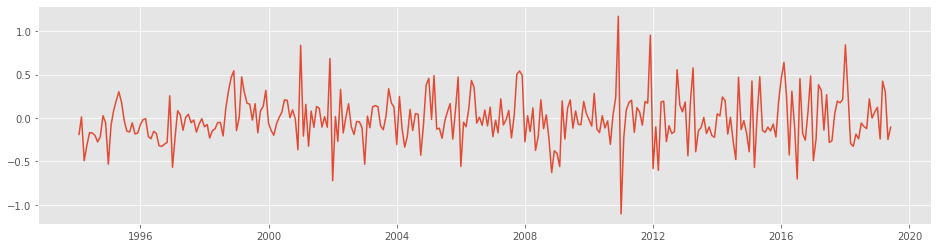

In [282]:
plt.figure(figsize=(16,4))
plt.plot(best_model.resid[13:]);

Визуально остатки выглядят несмещенными и стационарными. 

Проверим несмещенность с помощью критерия Стьюдента, а стационарность - с помощью критерия Дика-Фуллера

In [283]:
print('Критерий Стьюдетна, pvalue=%f' % stats.ttest_1samp(best_model.resid[13:], 0)[1])

Критерий Стьюдетна, pvalue=0.303215


Нулевая гиптоеза состоит в том, что остатки в среднем равны 0. Отвергнуть в пользу двусторонней альтернативы мы ее не можем. Это значит, что остатки можно считать несмещенными

In [284]:
print('Критерий Дика-Фуллера, pvalue=%.31f' % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Критерий Дика-Фуллера, pvalue=0.0000000000000000000000000000046


Нулевую гипотезу о том, что остатки нестационарны, мы отвергаем. Это значит, что остатки мы можем считать стационарными.

Итак, остатки несмещены и стационарны. Осталось только проверить отсутствие в них автокорреляции.

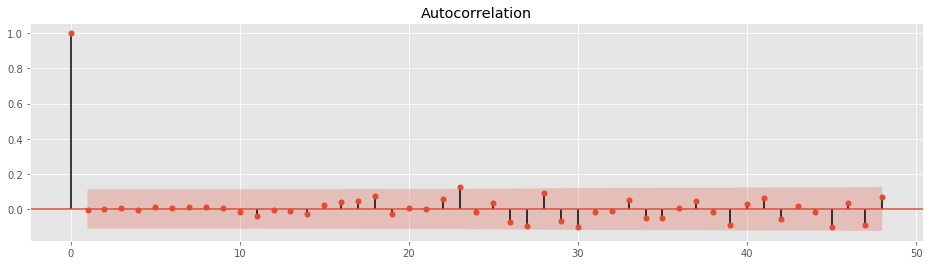

In [285]:
plt.figure(figsize=(16,4))
ax = plt.subplot(1,1,1)
sm.graphics.tsa.plot_acf(best_model.resid[13:], ax=ax, lags=48);

Остатки неавтокоррелированны. Это подтверждается как критерием Льюнга-Бокса (pvalue=0.86, нулевую гипотезу о том, что остатки неавтокоррелированны и автокорреляция при различных лагах равна 0, мы отвергнуть не можем) в описании нашей лучшей модели, так и визуально, на коррелограмме.

Посмотрим, как наша модель описывает данные:

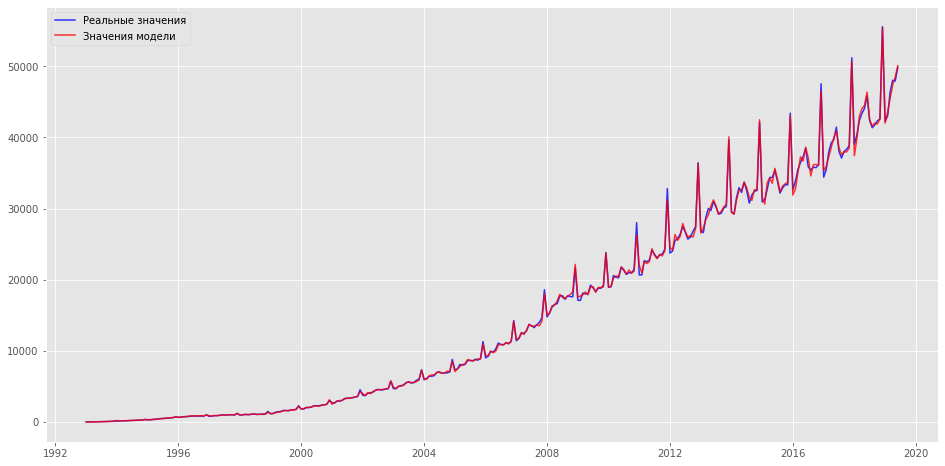

In [286]:
df['zp_model'] = inv_boxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(16,8))
plt.plot(df.index, df['zp'], c='blue', label='Реальные значения', alpha=0.8)
plt.plot(df.index, df['zp_model'], c='red', label='Значения модели', alpha=0.8)
plt.legend();

## Строим прогноз

In [287]:
zp = df[['zp']] # делаем отдельный датафрейм, куда будем писать предсказания
date_list = [datetime.datetime.strptime('2019-07-01', '%Y-%m-%d') + relativedelta(months=delta) for delta in range(0, 24)]
# делаем список дат для будущего предсказания

In [292]:
future = pd.DataFrame(index=date_list, columns=zp.columns)
zp = pd.concat([zp, future])
zp['forecast'] = inv_boxcox(best_model.predict(start=len(df) - 1, end=len(df) + 24 - 1), lmbda)

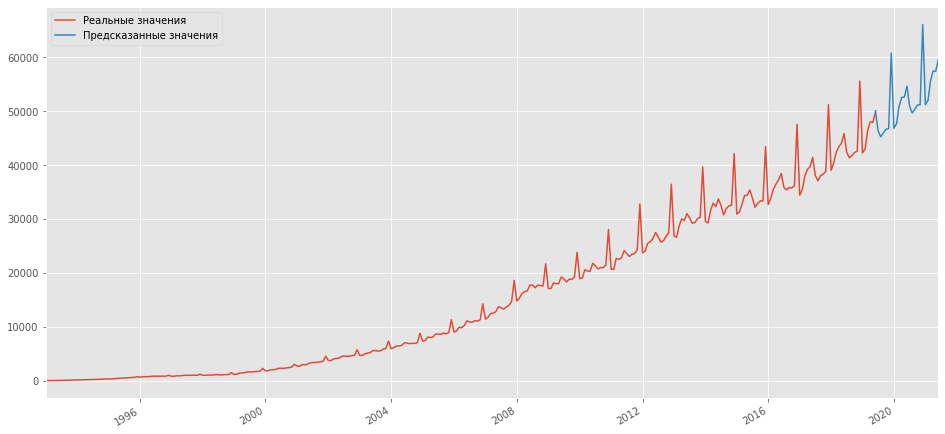

In [293]:
plt.figure(figsize=(16,8))
zp['zp'].plot(label='Реальные значения')
zp['forecast'].plot(label='Предсказанные значения')
plt.legend()
plt.show()

In [294]:
print('Ожидаемая средняя зарплата в РФ в июне 2021 (через 2 года после последних доступных данных) года: %.2f руб.' % zp['forecast'][-1])

Ожидаемая средняя зарплата в РФ в июне 2021 (через 2 года после последних доступных данных) года: 59601.35 руб.
